In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import expm
from numpy import matmul
from numpy.linalg import matrix_power, norm

In [3]:
Pauli0 = np.array([
    [1,0],
    [0,1]
])
PauliX = np.array([
    [0,1],
    [1,0]
])
PauliY = np.array([
    [0,-1j],
    [1j,0]
])
PauliZ = np.array([
    [1,0],
    [1,-1]
])

In [4]:
def spinHamiltonian(J = np.array([1,1,1])):
    '''
    funtion for retrieving
    spin-spin interaction
    Hamiltonian
    '''
    return J[0] * np.kron(PauliX, PauliX) + \
           J[1] * np.kron(PauliY, PauliY) + \
           J[2] * np.kron(PauliZ, PauliZ)

def fieldHamiltonian(H = np.array([1,1,1])):
    '''
    function for retrieving
    field interaction
    Hamiltonian
    '''
    return H[0] * (np.kron(PauliX, Pauli0) + np.kron(Pauli0, PauliX)) + \
           H[1] * (np.kron(PauliY, Pauli0) + np.kron(Pauli0, PauliY)) + \
           H[2] * (np.kron(PauliZ, Pauli0) + np.kron(Pauli0, PauliZ))

def totalHamiltonian(excInts = np.array([1,1,1]), field = np.array([1,1,1])):
    '''
    function for retrieving
    total hamiltonian
    '''
    return spinHamiltonian(excInts) + fieldHamiltonian(field)

In [5]:
def exactUnitary(t, **kwargs):
    '''
    function for retrieving
    exact evolution op
    '''
    return expm(-1j * t * totalHamiltonian(kwargs['excInts'], kwargs['field']))

def totalUnitary(t, STEPS=1, **kwargs):
    '''
    funcion for retrieving
    total evolution op
    '''
    dt = t / STEPS
    timeSlice = matmul(expm(-1j * dt * spinHamiltonian(kwargs['excInts'])) , \
                expm(-1j * dt * fieldHamiltonian(kwargs['field'])))
    # timeSlice = matmul(expm(-1j * dt/2 * spinHamiltonian(kwargs['excInts'])) , \
    #             matmul(expm(-1j * dt * fieldHamiltonian(kwargs['field'])), \
    #                    expm(-1j * dt/2 * spinHamiltonian(kwargs['excInts']))))
    return matrix_power(timeSlice, STEPS)

def frobDistance(t, STEPS=1, **kwargs):
    '''
    Error estimation using
    frobenius distance
    '''
    return norm(totalUnitary(t=t, STEPS=STEPS, excInts=kwargs['excInts'], field=kwargs['field']) - \
                exactUnitary(t=t, excInts=kwargs['excInts'], field=kwargs['field']))

def meanFrobDistance(t, STEPS=1, SHOTS=1000):
    '''
    Mean error under field and exchange
    integrals
    '''
    return sum(frobDistance(t, STEPS=STEPS, excInts=np.random.random(3), field=np.random.random(3)) \
                  for _ in range(SHOTS)) / SHOTS

def stateFidelity(t, STEPS=1, **kwargs):
    '''
    State fidelity of ST
    evolution
    '''
    unitOp = matmul(totalUnitary(t=t, STEPS=STEPS, excInts=kwargs['excInts'], field=kwargs['field']).conj().T,
                    exactUnitary(t=t, excInts=kwargs['excInts'], field=kwargs['field']))
    return np.abs(matmul(kwargs['state'].conj().T, matmul(unitOp, kwargs['state']))) / \
           sum(np.abs(kwargs['state']) ** 2)
           

def meanStateFidelity(t, STEPS=1, SHOTS=1000):
    '''
    mean state fidelity
    '''
    return sum(stateFidelity(t, STEPS=STEPS, excInts=np.random.random(3), field=np.random.random(3), \
               state=np.random.random(4)) for _ in range(SHOTS))/SHOTS

In [6]:
J = np.array([1,1,1])
H = np.array([1,1,1])
t = 1
STEPS = 40
print(np.abs(exactUnitary(t, excInts=J, field=H)))
print(np.abs(totalUnitary(t, STEPS=STEPS, excInts=J, field=H)))
print(frobDistance(t, STEPS=STEPS, excInts=J, field=H))

[[0.65356525 0.11676239 0.11676239 0.64364361]
 [0.35931438 0.45376032 0.61328747 0.80330828]
 [0.35931438 0.61328747 0.45376032 0.80330828]
 [1.37726077 0.82283403 0.82283403 0.28758093]]
[[0.64435414 0.10934825 0.10934825 0.64365611]
 [0.35261612 0.45990672 0.60445057 0.8085633 ]
 [0.35261612 0.60445057 0.45990672 0.8085633 ]
 [1.3821975  0.81890197 0.81890197 0.29766143]]
0.04088099284579252


In [66]:
steps_array = np.fromiter(range(4,STEPS+1), dtype='int')
frob_errors = np.array([meanFrobDistance(t, STEPS=steps, SHOTS=500) for steps in steps_array])

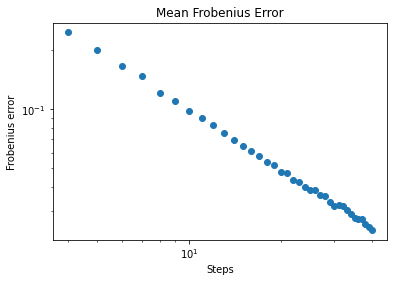

In [67]:
plt.title('Mean Frobenius Error')
plt.ylabel('Frobenius error')
plt.yscale('log')
plt.xlabel('Steps')
plt.xscale('log')
plt.scatter(steps_array, frob_errors)
plt.show()

In [68]:
X = np.log(steps_array)
Y = np.log(frob_errors)
exponent, const = np.polyfit(X, Y, 1)
print(exponent)

-1.0064327256424568


In [80]:
fidelities = np.array([meanStateFidelity(t, STEPS=steps, SHOTS=500) for steps in steps_array])

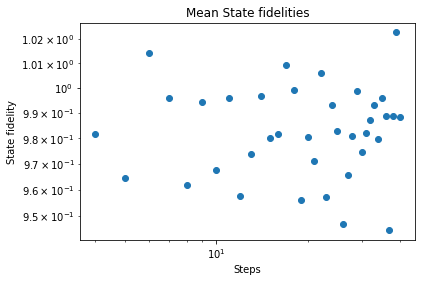

In [83]:
plt.clf()
plt.title('Mean State fidelities')
plt.ylabel('State fidelity')
plt.yscale('log')
plt.xlabel('Steps')
plt.xscale('log')
plt.scatter(steps_array, fidelities)
plt.show()